# COGS 108 - Final Project

## Important

- ONE, and only one, member of your group should upload this notebook to TritonED. 
- Each member of the group will receive the same grade on this assignment. 
- Keep the file name the same: submit the file 'FinalProject.ipynb'.
- Only upload the .ipynb file to TED, do not upload any associted data. Make sure that for cells in which you want graders to see output that these cells have been executed.

## Group Members: Fill in the Student IDs of each group member here

Replace the lines below to list each persons full student ID, ucsd email and full name.

-  
- 
- 
- 



# Part 0 - Importing the required packages

In [1]:
import pandas as pd # for use of dataframes
import numpy as np
import matplotlib.pyplot as plt # for plotting graphs 
import statsmodels.api as sm # for fitting an OLS model
import scipy.stats as stats # for access to tests for normal distribution
from scipy.stats import ttest_ind, normaltest # for access to t tests, normal test
%matplotlib inline

# Part 1 - Introduction and Background

Chicago, otherwise known as 'The Windy City', has some of the worst crime rates in America. Some of this has to do with statitical flukes; it is the third largest city in the U.S., which makes any type of criminal activity more easily reportable. However, most people wouldn't argue over the real danger you are in when you go to some of the worse off areas of Chicago.

We wanted to analyze the crime rates in Chicago in some way in order to assist people in the city in understanding what problems exist and where they are happening. In the end, we decided to ask the following question:

"Does the district a crime is committed in or type of crime more closely predict whether an arrest was made".

The answers derived from the answer to this question could spawn further analysis, e.g.:

1. If a particular crime is more likely to result in an arrest in one district over the other, why is that? Is it the police in that district? Is it the citizens? Or is it the geography?

2. If the type of crime affects whether an arrest is made, does that mean that we are more afraid of certain crimes over others? Is this a valid fear? 

# Part 2 - Data Description

We are using this dataset: https://www.kaggle.com/chicago/chicago-crime

This is chicago crime data from 2001 to present. It represents all reported instances of crime, and whether or not an arrest has been made since the data was last released. Each row represents a crime, except for multiple homicides, for which there is a different row for each victim of the crime. 

Here are some basic stats:

In [2]:
crime = pd.read_csv('/Users/alvin/Downloads/CrimesSmall.csv')

In [3]:
crime.describe()

,ID,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Year,Latitude,Longitude
count,1.999000e+03,1999.000000,1999.000000,1991.000000,1989.000000,1.988000e+03,1.988000e+03,1999.000000,1988.000000,1988.000000
mean,7.892279e+06,1199.812406,11.340170,22.699146,38.602313,1.164586e+06,1.883800e+06,2010.863432,41.836745,-87.671610
std,5.965758e+05,705.621225,6.976461,13.437493,21.603693,1.608752e+04,3.185389e+04,0.951716,0.087604,0.058523
min,1.961551e+06,111.000000,1.000000,1.000000,1.000000,1.117615e+06,1.814534e+06,2001.000000,41.646343,-87.842868
25%,7.957218e+06,621.000000,6.000000,11.000000,23.000000,1.152836e+06,1.857924e+06,2011.000000,41.765687,-87.714182
50%,7.957867e+06,1111.000000,10.000000,22.000000,34.000000,1.165511e+06,1.887310e+06,2011.000000,41.846341,-87.667811
75%,7.958476e+06,1732.000000,17.000000,34.000000,60.000000,1.176520e+06,1.908376e+06,2011.000000,41.904272,-87.627847
max,7.959109e+06,2535.000000,25.000000,50.000000,77.000000,1.203816e+06,1.951242e+06,2011.000000,42.021808,-87.529246


In [4]:
print('Total Number of Crimes:\t\t\t{0}'.format(len(crime)))
print('Total number of Unique Districts:\t{0}'.format(len(crime['District'].unique())))

Total Number of Crimes:			1999
Total number of Unique Districts:	22


# Part 3 - Data Cleaning and Preprocessing

This data is fairly clean, because it is maintained by the Chicago Police Department, which has high organizational standards. There aren't very many invalid crimes or unknowns.

To clean the data, we will do the following (not necessarily in order):

1. Drop useless columns
2. Standardize the location description
3. Standardize the crime type to get rid of the uppercase, standardize the non-criminal type
4. Remove NaN values

In [5]:
# first, drop the location description column and community area column because 
crime = crime.drop(['Location Description','Community Area','Latitude','Longitude','X Coordinate','Y Coordinate','Location','Ward'],axis=1)

In [6]:
def standardize_primary_type(string):
    # compile all non-criminal offenses into on label
    if string == 'NON-CRIMINAL (SUBJECT SPECIFIED)' or string == 'NON - CRIMINAL' or string == 'NON-CRIMINAL':
        return 'non-criminal'
    if string == 'OTHER OFFENSE':
        return 'other'
    # rename crim sexual assault to just sexual assault to make it easier to read
    if string == 'CRIM SEXUAL ASSAULT':
        return 'sexual assault'
    else:
        # everything else, make sure to lowercase it so we don't have to use caps lock lol
        return string.lower()
        

In [7]:
# Standardize the crime type
crime['Type'] = crime['Primary Type'].apply(standardize_primary_type)

In [8]:
crime[crime.isnull().any(axis=1)]

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Arrest,Domestic,Beat,District,FBI Code,Year,Updated On,Type


In [9]:
crime

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Arrest,Domestic,Beat,District,FBI Code,Year,Updated On,Type
0,7956475,HT188097,3/4/2011 10:52,025XX S KILDARE AVE,554,ASSAULT,AGG PO HANDS NO/MIN INJURY,True,False,1013,10,08A,2011,2/10/2018 15:50,assault
1,7956476,HT185132,3/4/2011 12:00,024XX W 45TH PL,1150,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,False,False,914,9,11,2011,2/10/2018 15:50,deceptive practice
2,7956477,HT187881,3/4/2011 9:00,023XX N CLYBOURN AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,False,False,1811,18,14,2011,2/10/2018 15:50,criminal damage
3,7956479,HT187939,3/3/2011 8:00,003XX W 100TH ST,890,THEFT,FROM BUILDING,False,False,511,5,6,2011,2/10/2018 15:50,theft
4,7956480,HT187986,3/4/2011 10:35,065XX W BRYN MAWR AVE,460,BATTERY,SIMPLE,True,False,1612,16,08B,2011,2/10/2018 15:50,battery
5,7956485,HT188051,3/4/2011 0:00,042XX N HERMITAGE AVE,1150,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,False,False,1922,19,11,2011,2/10/2018 15:50,deceptive practice
6,7956486,HT188132,3/4/2011 11:46,043XX S PRAIRIE AVE,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,True,False,222,2,18,2011,2/10/2018 15:50,narcotics
7,7956488,HT188001,3/3/2011 22:40,041XX N WHIPPLE ST,910,MOTOR VEHICLE THEFT,AUTOMOBILE,False,False,1724,17,7,2011,2/10/2018 15:50,motor vehicle theft
8,7956490,HT188163,3/4/2011 10:00,043XX W IRVING PARK RD,2851,PUBLIC PEACE VIOLATION,ARSON THREAT,False,False,1731,17,26,2011,2/10/2018 15:50,public peace violation
9,7956494,HT188139,3/4/2011 12:05,005XX W HARRISON ST,560,ASSAULT,SIMPLE,False,True,131,1,08A,2011,2/10/2018 15:50,assault


# Part 4 - Data Visualization

First, we want to look at the top three crime types

In [10]:
crime['Primary Type'].value_counts().nlargest(3)

BATTERY      418
THEFT        383
NARCOTICS    266
Name: Primary Type, dtype: int64

<BarContainer object of 23 artists>

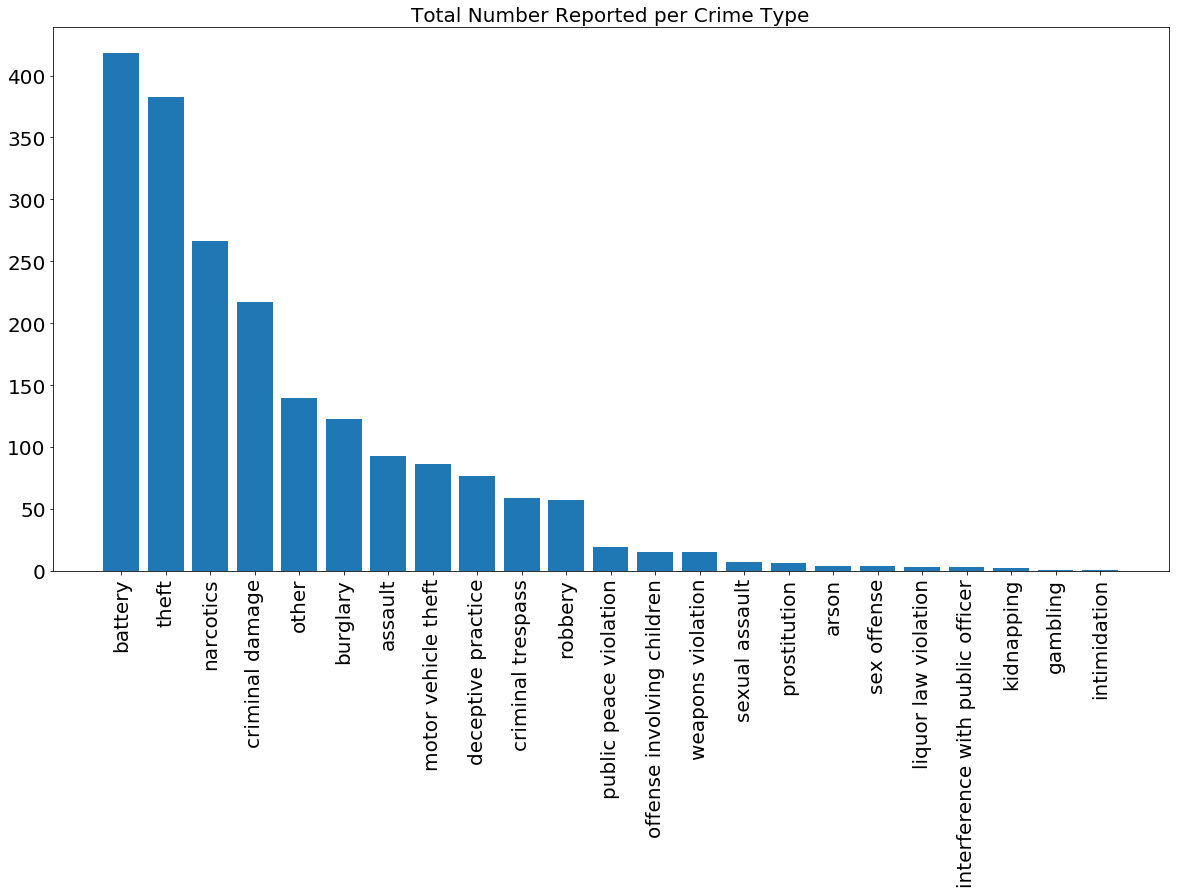

In [33]:
plt.figure(figsize=(20,10))
crimeType = plt.bar(crime.Type.value_counts().index, crime.Type.value_counts())
plt.title('Total Number Reported per Crime Type', fontsize='20')
plt.xticks(rotation='vertical')
plt.tick_params(labelsize=20)
crimeType

Let's first get the total count of crimes that were reported at each district and visualize them in a bar graph for easy comparison.

In [39]:
districts = crime['District'].unique()
district_cache = {}
arrest_cache = {}
ratio_cache = {}
for district in districts:
    district_cache[district] = len(crime[ crime['District'] == district ]) #gets total num of crimes in each district
    arrest_cache[district] = len(crime[ (crime['Arrest'] == True) & (crime['District'] == district)]) #gets total num of arrests per district
    ratio_cache[district] = arrest_cache[district] / district_cache[district] 
print(district_cache)
print(arrest_cache)
print(ratio_cache)

{10: 89, 9: 91, 18: 88, 5: 102, 16: 61, 19: 66, 2: 92, 17: 73, 1: 68, 15: 87, 8: 145, 22: 98, 6: 95, 14: 91, 12: 81, 7: 114, 3: 115, 11: 126, 25: 117, 4: 121, 20: 32, 24: 47}
{10: 21, 9: 34, 18: 29, 5: 25, 16: 14, 19: 16, 2: 33, 17: 21, 1: 23, 15: 43, 8: 44, 22: 18, 6: 35, 14: 20, 12: 19, 7: 38, 3: 45, 11: 45, 25: 37, 4: 26, 20: 4, 24: 12}
{10: 0.23595505617977527, 9: 0.37362637362637363, 18: 0.32954545454545453, 5: 0.24509803921568626, 16: 0.22950819672131148, 19: 0.24242424242424243, 2: 0.358695652173913, 17: 0.2876712328767123, 1: 0.3382352941176471, 15: 0.4942528735632184, 8: 0.30344827586206896, 22: 0.1836734693877551, 6: 0.3684210526315789, 14: 0.21978021978021978, 12: 0.2345679012345679, 7: 0.3333333333333333, 3: 0.391304347826087, 11: 0.35714285714285715, 25: 0.3162393162393162, 4: 0.21487603305785125, 20: 0.125, 24: 0.2553191489361702}


In [44]:
districtsTotalCrime = pd.DataFrame.from_dict(district_cache, orient='index')
districtsTotalCrime.columns = ['Total Crimes Reported']
districtsTotalCrime.index.name = 'District Number'
districtsTotalCrime.head()

,Total Crimes Reported
District Number,
10,89
9,91
18,88
5,102
16,61


From this bar chart, we can see that the two districts with the msot crimes reported were Districts 8 and 11 while the two districts that had the least crimes reported were Districts 20 and 24. 

However, let's dive deeper into our data (specifically in the top three crime types). 

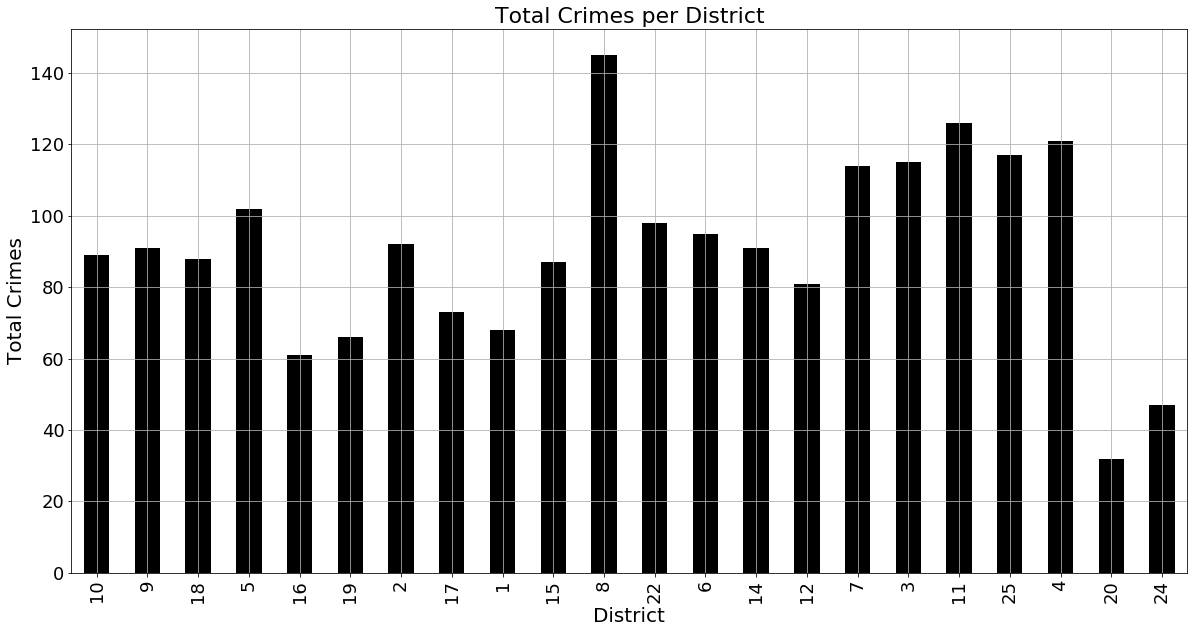

In [43]:
DTCchart = districtsTotalCrime.plot(kind='bar', grid=True, figsize=(20,10), legend=False, color='k')
DTCchart.set_title('Total Crimes per District', fontsize=22)
DTCchart.set_xlabel('District', fontsize=20)
DTCchart.set_ylabel('Total Crimes', fontsize=20)
DTCchart.tick_params(labelsize=18)
DTCchart

In [42]:
districtsRatio = pd.DataFrame.from_dict(ratio_cache, orient='index')
districtsRatio.columns = ['Arrest to Crime Ratio']
districtsRatio.index.name = 'District Number'
districtsRatio.head()

,Arrest to Crime Ratio
District Number,
10,0.235955
9,0.373626
18,0.329545
5,0.245098
16,0.229508


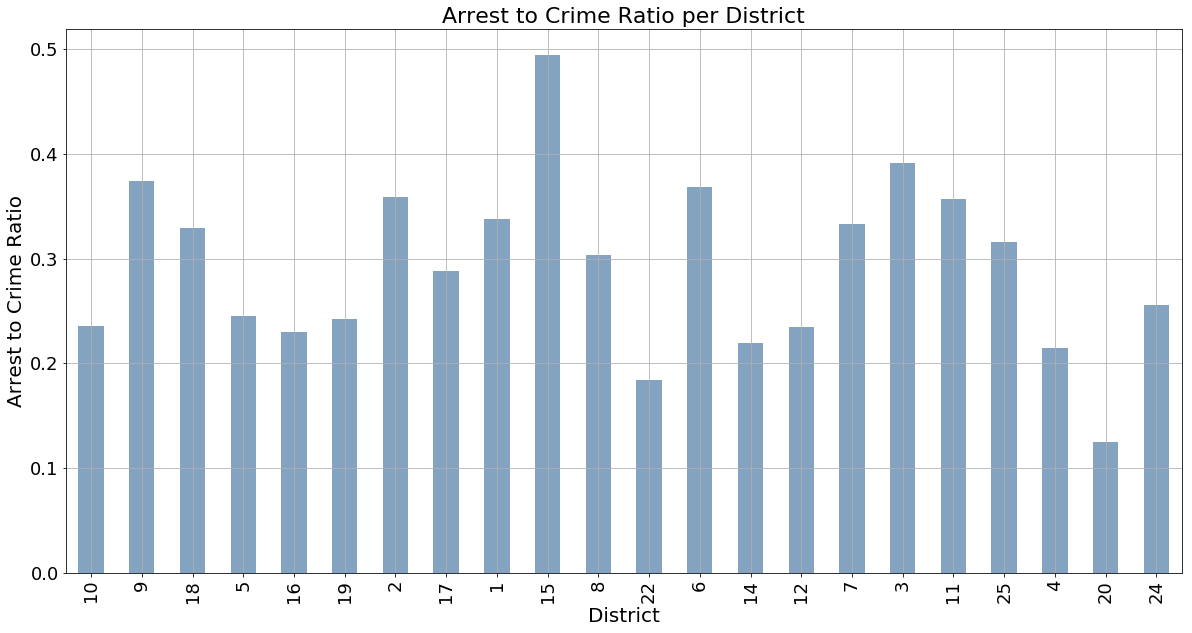

In [41]:
ratioChart = districtsRatio.plot(kind='bar', grid=True, figsize=(20,10), legend=False, color=(0.2, 0.4, 0.6, 0.6))
ratioChart.set_title('Arrest to Crime Ratio per District', fontsize=22)
ratioChart.set_xlabel('District', fontsize=20)
ratioChart.set_ylabel('Arrest to Crime Ratio', fontsize=20)
ratioChart.tick_params(labelsize=18)
ratioChart

In [15]:
dist_pred_arrest = pd.DataFrame()
for district in districts:
    arrest_occurred = crime[crime['Arrest'] == True]   
    
    dist_pred_arrest.loc[district, 'Reported Theft'] = len(crime[(crime['Primary Type'] == 'THEFT') & (crime['District'] == district)]) 
    dist_pred_arrest.loc[district,'Theft w/ Arrest Made'] = len(arrest_occurred[(arrest_occurred['Primary Type'] == 'THEFT') & (arrest_occurred['District'] == district)])
    dist_pred_arrest.loc[district,'Theft Arrest Rate'] = dist_pred_arrest.loc[district,'Theft w/ Arrest Made'] / dist_pred_arrest.loc[district,'Reported Theft']
    
    dist_pred_arrest.loc[district, 'Reported Battery'] = len(crime[(crime['Primary Type'] == 'BATTERY') & (crime['District'] == district)]) 
    dist_pred_arrest.loc[district,'Battery w/ Arrest Made'] = len(arrest_occurred[(arrest_occurred['Primary Type'] == 'BATTERY') & (arrest_occurred['District'] == district)])
    dist_pred_arrest.loc[district,'Battery Arrest Rate'] = dist_pred_arrest.loc[district,'Battery w/ Arrest Made'] / dist_pred_arrest.loc[district,'Reported Battery']
    
    dist_pred_arrest.loc[district, 'Reported Criminal Damage'] = len(crime[(crime['Primary Type'] == 'CRIMINAL DAMAGE') & (crime['District'] == district)]) 
    dist_pred_arrest.loc[district,'Criminal Damage w/ Arrest Made'] = len(arrest_occurred[(arrest_occurred['Primary Type'] == 'CRIMINAL DAMAGE') & (arrest_occurred['District'] == district)])
    dist_pred_arrest.loc[district,'Criminal Damage Arrest Rate'] = dist_pred_arrest.loc[district,'Criminal Damage w/ Arrest Made'] / dist_pred_arrest.loc[district,'Reported Criminal Damage']
    
print(dist_pred_arrest) 

    Reported Theft  Theft w/ Arrest Made  Theft Arrest Rate  Reported Battery  \
10            13.0                   0.0           0.000000              24.0   
9             10.0                   1.0           0.100000              17.0   
18            38.0                  13.0           0.342105              11.0   
5             18.0                   0.0           0.000000              26.0   
16             5.0                   0.0           0.000000              16.0   
19            16.0                   2.0           0.125000               8.0   
2             14.0                   2.0           0.142857              23.0   
17            13.0                   1.0           0.076923              15.0   
1             33.0                   7.0           0.212121               3.0   
15             5.0                   1.0           0.200000              18.0   
8             25.0                   4.0           0.160000              23.0   
22            16.0          

Previously, we found out the top three crime types (in terms of total reports). From the dataframe above, we are able to gain access to the number of each of these three crime reported, number of arrests that stemmed from each crime, and the arrest ratio, for each district. Now, we can plot this data to see it all visually.  

First, let's see the ratios of our top 3 crimes arrest per district.

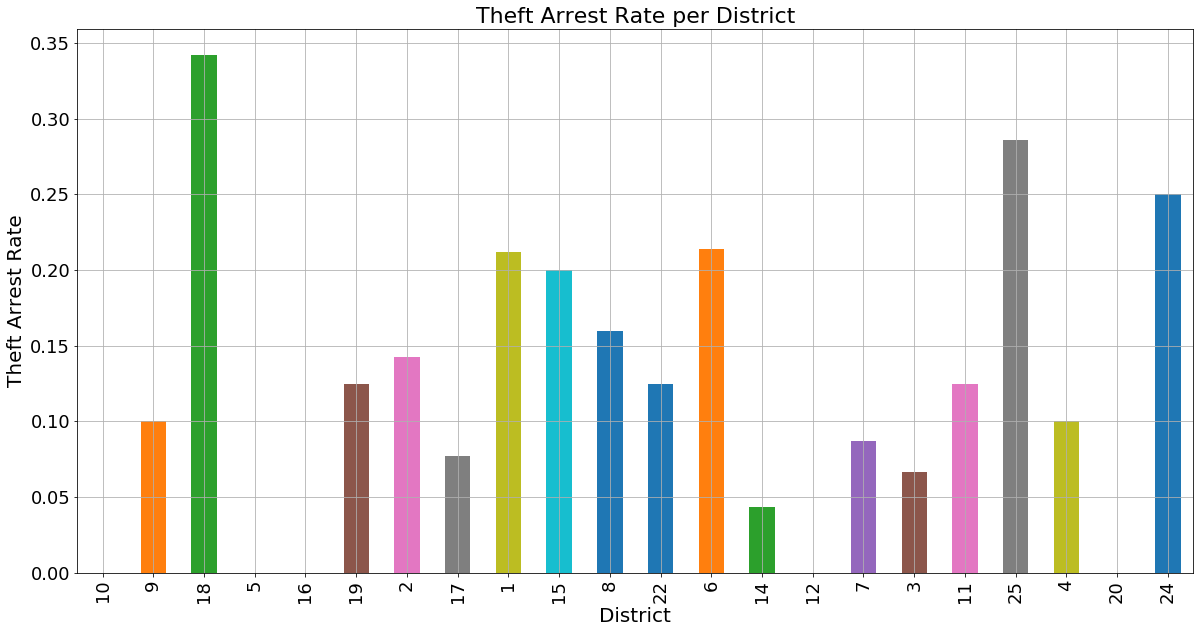

In [16]:
thefts = dist_pred_arrest['Theft Arrest Rate'] 
theftRate = thefts.plot(kind='bar', grid=True, figsize=(20,10), legend=False) 
theftRate.set_title('Theft Arrest Rate per District', fontsize=22)
theftRate.set_xlabel('District', fontsize=20)
theftRate.set_ylabel('Theft Arrest Rate', fontsize=20)
theftRate.tick_params(labelsize=18)
theftRate

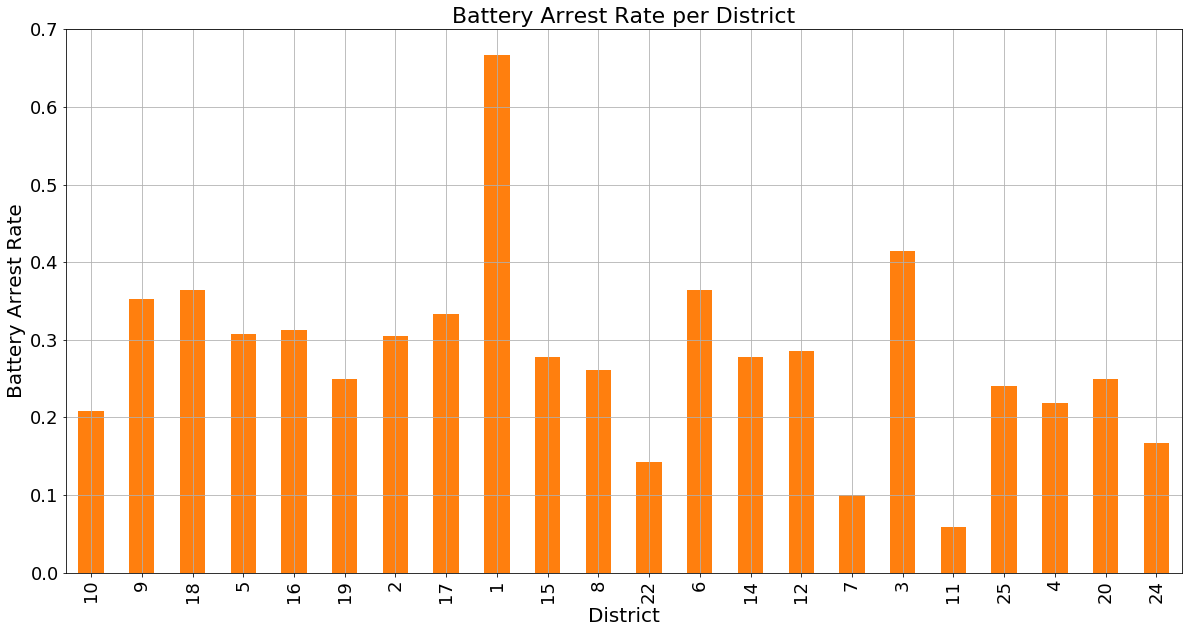

In [17]:
battery = dist_pred_arrest['Battery Arrest Rate'] 
batteryRate = battery.plot(kind='bar', grid=True, figsize=(20,10), legend=False, color='tab:orange') 
batteryRate.set_title('Battery Arrest Rate per District', fontsize=22)
batteryRate.set_xlabel('District', fontsize=20)
batteryRate.set_ylabel('Battery Arrest Rate', fontsize=20)
batteryRate.tick_params(labelsize=18)
batteryRate

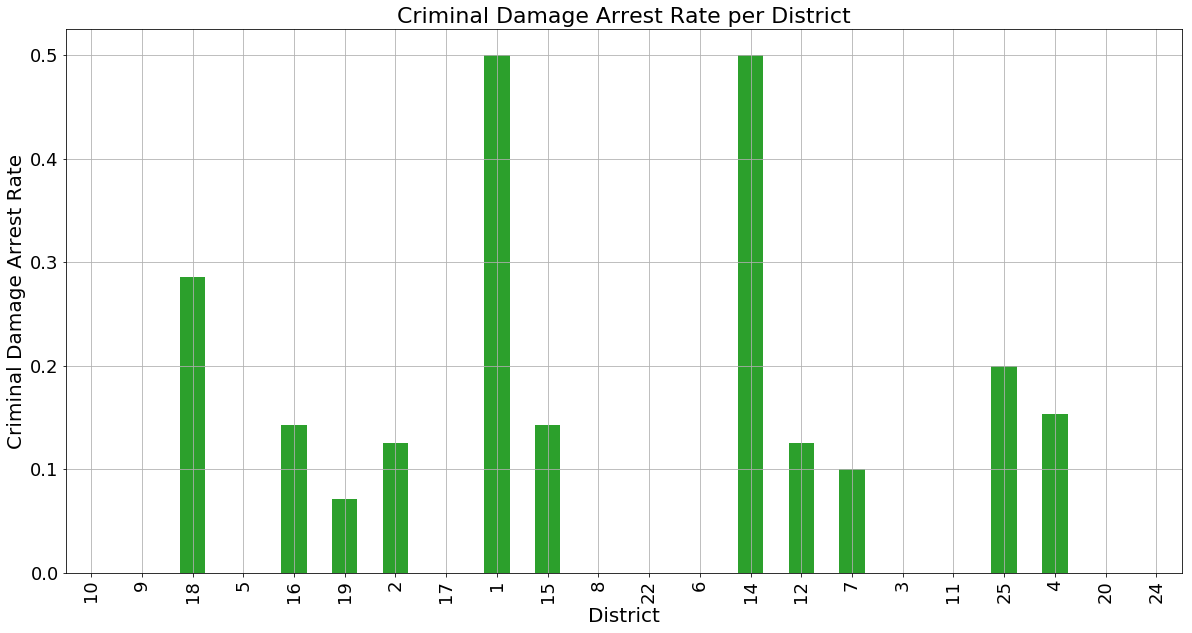

In [18]:
criminal = dist_pred_arrest['Criminal Damage Arrest Rate'] 
criminalRate = criminal.plot(kind='bar', grid=True, figsize=(20,10), legend=False, color='tab:green') 
criminalRate.set_title('Criminal Damage Arrest Rate per District', fontsize=22)
criminalRate.set_xlabel('District', fontsize=20)
criminalRate.set_ylabel('Criminal Damage Arrest Rate', fontsize=20)
criminalRate.tick_params(labelsize=18)
criminalRate

# Part 5 - Data Analysis and Results

# Part 6 - Privacy/Ethics Considerations

# Part 7 - Conclusions and Discussion